torch.version:  2.0.1+cu117
torch.version.cuda:  11.7
torch.cuda.is_available:  True
torch.cuda.device_count:  1
torch.cuda.current_device:  0
torch.cuda.get_device_name:  Tesla V100S-PCIE-32GB
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReL

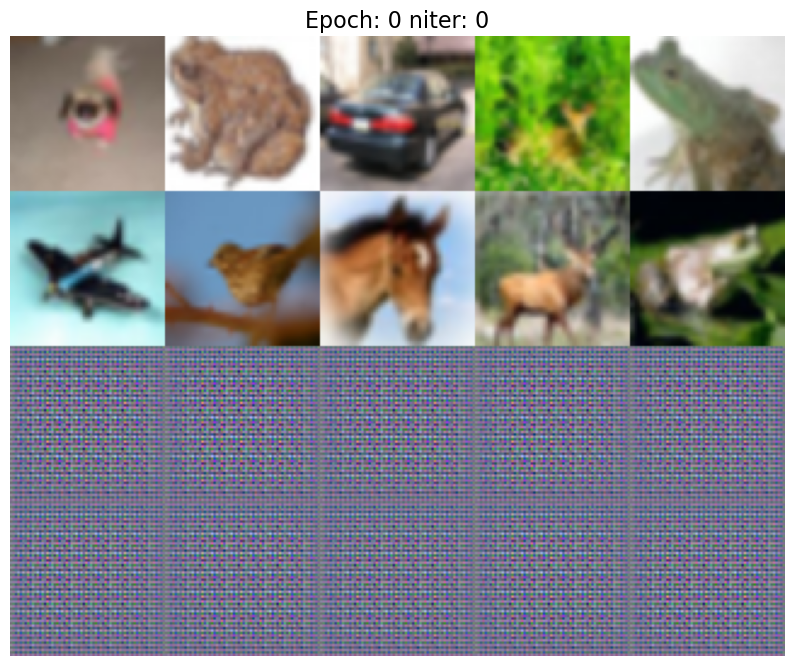

[1/20][0/500] Loss_D: 0.0322 Loss_G: 0.0655


KeyboardInterrupt: 

In [10]:
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
import torchvision.transforms as transform_module
from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader

TOTAL_EPOCHS = 20
BATCH_SIZE = 100
WORKER_COUNT = 0

RANDOM_SEED = 2099

IMG_SIZE = 64
LEARNING_RATE = 0.0002
INPUT_NOISE_DIM = 100

overall_start_time = time.time()

print('torch.version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)
print('torch.cuda.is_available: ', torch.cuda.is_available())
print('torch.cuda.device_count: ', torch.cuda.device_count())
print('torch.cuda.current_device: ', torch.cuda.current_device())
default_device = torch.cuda.current_device()
torch.cuda.device(default_device)
print('torch.cuda.get_device_name: ', torch.cuda.get_device_name(default_device))
device = torch.device("cuda")

transform_pipeline = transforms.Compose([transforms.Resize(IMG_SIZE),
                                         transforms.CenterCrop(IMG_SIZE),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5),
                                                              (0.5, 0.5, 0.5)),
                                         ])

data_set = torchvision.datasets.CIFAR10(root="./data/", 
                                        download=True,
                                        transform=transform_pipeline)

data_loader = torch.utils.data.DataLoader(data_set, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, 
                                          num_workers=WORKER_COUNT)

print(data_set.classes)
print(data_set.data.shape)

class ImageGenerator(nn.Module):
    def __init__(self, input_dim = INPUT_NOISE_DIM):
        super(ImageGenerator, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_tensor):
        return self.layer_stack(input_tensor)

    def set_weights(self, mean_w=0, std_w=0.02, mean_b=1, std_b=0.02):
        for layer in self.modules():
            layer_type = layer.__class__.__name__
            if layer_type.find('Conv') != -1:
                nn.init.normal_(layer.weight.data, mean_w, std_w)
            elif layer_type.find('BatchNorm') != -1:
                nn.init.normal_(layer.weight.data, mean_b, std_b)
                nn.init.constant_(layer.bias.data, 0)

device = torch.device("cuda")
generator = ImageGenerator().to(device)
summary(generator, input_size=(100,1,1))

class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

    def forward(self, input_tensor):
        return self.layer_stack(input_tensor)

    def set_weights(self, mean_w=0, std_w=0.02, mean_b=1, std_b=0.02):
        for layer in self.modules():
            layer_type = layer.__class__.__name__
            if layer_type.find('Conv') != -1:
                nn.init.normal_(layer.weight.data, mean_w, std_w)
            elif layer_type.find('BatchNorm') != -1:
                nn.init.normal_(layer.weight.data, mean_b, std_b)
                nn.init.constant_(layer.bias.data, 0)

device = torch.device("cuda")
discriminator = ImageDiscriminator().to(device)
summary(discriminator, input_size=(3,64,64))

def normalize_image(image_data):
    normalized_data = ((image_data-np.min(image_data))/(np.max(image_data)-np.min(image_data))*255).astype(np.uint8)
    return normalized_data

def create_image_grid(images):
    sample_image = images[random.randint(0, 9)].detach().permute(1,2,0).cpu().numpy()
    first_row_images = np.array([])
    for i in range(0,5):
        current_image = images[i].detach().permute(1,2,0).cpu().numpy()
        if i == 0: first_row_images = current_image
        else: first_row_images = np.hstack((first_row_images,current_image))
        
    second_row_images = np.array([])            
    for i in range(5,10):
        current_image = images[i].detach().permute(1,2,0).cpu().numpy()
        if i == 5: second_row_images = current_image
        else: second_row_images = np.hstack((second_row_images,current_image))
        
    full_image_grid = np.vstack((first_row_images,second_row_images))
    normalized_full_grid = normalize_image(full_image_grid)
    normalized_sample_image = normalize_image(sample_image)
    return normalized_full_grid, normalized_sample_image

torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rms_optimizer_gen = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
rms_optimizer_disc = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

input_noise_tensor = torch.randn(BATCH_SIZE, INPUT_NOISE_DIM, 1, 1)
input_noise_tensor = input_noise_tensor.to(device)

real_label_value = 1.0
fake_label_value = 0.0

DISC_TRAINING_STEPS = 1
GEN_TRAINING_STEPS = 1
gen_loss_records = []
disc_loss_records = []
saved_image_list = []
saved_frame_list = []

print('start training...')
print('Epochs: %d | Batch Size: %d | Learning Rate: %.4f' % (TOTAL_EPOCHS, BATCH_SIZE, LEARNING_RATE))
generator.train(True)
discriminator.train(True)
training_start_time = time.time()

for epoch in range(TOTAL_EPOCHS):
    for i, batch_data in enumerate(data_loader):
        
        for k in range(DISC_TRAINING_STEPS):
            rms_optimizer_disc.zero_grad()
            noise_tensor = torch.randn(BATCH_SIZE, INPUT_NOISE_DIM, 1, 1, device=device)
    
            real_images = batch_data[0].to(device)
            generated_images = generator(noise_tensor)
            
            real_disc_output = discriminator(real_images)
            fake_disc_output = discriminator(generated_images)
            disc_loss = -torch.mean(real_disc_output - fake_disc_output)
            
            disc_loss.backward()
            rms_optimizer_disc.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
    
        for m in range(GEN_TRAINING_STEPS):
            rms_optimizer_gen.zero_grad()
            
            noise_tensor = torch.randn(BATCH_SIZE, INPUT_NOISE_DIM, 1, 1, device=device)
            generated_images = generator(noise_tensor)
            
            fake_disc_output = discriminator(generated_images)
            gen_loss = -torch.mean(fake_disc_output)
            
            gen_loss.backward()
            rms_optimizer_gen.step()
            
        gen_loss_records.append(gen_loss.item())
        disc_loss_records.append(disc_loss.item())

        if i % (len(data_loader)//25) == 0:
            discriminator.eval()
            generator.eval()
            
            test_noise = torch.randn(10, INPUT_NOISE_DIM, 1, 1, device=device)
            test_generated_images = generator(test_noise)
            
            test_generated_grid, sample_generated_image = create_image_grid(test_generated_images)
            test_real_images, _ = create_image_grid(real_images)
            full_test_images = np.vstack((test_real_images, test_generated_grid))
            
            plt.figure(figsize=(10,10))
            plt.imshow(full_test_images)
            plt.axis('off')
            plt.title('Epoch: %d niter: %d'%(epoch,i),fontsize=16)
            plt.show()
            
            saved_frame_list.append(sample_generated_image)
            saved_image_list.append(test_generated_images)
            
            loop_end_time = time.time()
            loop_duration = loop_end_time - training_start_time
            training_start_time = time.time()
            
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (
                epoch+1, TOTAL_EPOCHS, i, len(data_loader), disc_loss.item(), gen_loss.item()))

            discriminator.train()
            generator.train()

    plt.figure(figsize=(20,10))
    plt.plot(gen_loss_records, label='Generator')
    plt.plot(disc_loss_records, label='Discriminator')
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.title('Training Losses',fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('WGAN_loss_chart.png')
    plt.show()
    torch.save(generator.state_dict(), './weights/WGAN_Gen_weights.pth')
    torch.save(discriminator.state_dict(), './weights/WGAN_Disc_weights.pth')

overall_end_time = time.time()
print('Done! Total time cost: ', overall_end_time-overall_start_time)
timestamp = time.strftime("%Y%m%d_%H%M", time.localtime()) 
torch.save(generator.state_dict(), './weights/WGAN_Gen_'+timestamp+'.pth')
torch.save(discriminator.state_dict(), './weights/WGAN_Disc_'+timestamp+'.pth')

def display_epoch_images(image_list):
    num_images = len(image_list)

    selected_images = []
    epoch_interval = num_images//TOTAL_EPOCHS
    for i in range(0, num_images, epoch_interval):
        index = random.randint(i, i+epoch_interval-1)
        selected_images.append(image_list[index])
        
    num_selected_images = len(selected_images) 
    columns = 10
    rows = num_selected_images//columns
    
    final_image_grid = np.array([])
    for i in range(rows):
        row_images = np.array([])
        for j in range(columns):
            current_image = selected_images[i*columns + j]
            if j==0: row_images = current_image
            else: row_images = np.hstack((row_images,current_image))
        
        if i==0: final_image_grid = row_images
        else: final_image_grid = np.vstack((final_image_grid,row_images))
    
    return final_image_grid
   
final_images = display_epoch_images(saved_frame_list)     

          
plt.figure(figsize=(10,10))
plt.imshow(final_images)
plt.axis('off')
plt.title('WGAN Epochs:%d Batch:%d Disc/Gen: %d/%d' % (
            epoch, BATCH_SIZE, DISC_TRAINING_STEPS, GEN_TRAINING_STEPS),fontsize=20)
plt.savefig('WGAN_final_image_grid.png')
plt.show()

cv2.imwrite('WGAN_final_image_grid.png', cv2.cvtColor(final_images, cv2.COLOR_BGR2RGB))

def evaluate_model(number_of_images):
    discriminator.eval()
    generator.eval()
    
    best_images = []
    scores = []
    count = 0
    
    while count < number_of_images:
        test_noise = torch.randn(1, INPUT_NOISE_DIM, 1, 1, device=device)
        test_image = generator(test_noise)
        test_score = discriminator(test_image).detach().cpu().numpy()[0][0][0][0]
        scores.append(test_score)
        if test_score < -0.5:
            print(test_score)
            image = test_image.detach().permute(0,2,3,1).cpu().numpy()[0]
            normalized_image = normalize_image(image)
            best_images.append(normalized_image)
            count += 1

    return best_images, scores

best_image_collection, image_scores = evaluate_model(20)
plt.plot(image_scores)

def display_best_images(image_collection):
    num_images = len(image_collection)

    columns = 5
    rows = num_images // columns
    
    combined_images = np.array([])
    for i in range(rows):
        row_image_combination = np.array([])
        for j in range(columns):
            individual_image = image_collection[i*columns + j]
            if j == 0: row_image_combination = individual_image
            else: row_image_combination = np.hstack((row_image_combination, individual_image))
        
        if i == 0: combined_images = row_image_combination
        else: combined_images = np.vstack((combined_images, row_image_combination))
    
    return combined_images

final_best_images = display_best_images(best_image_collection)

plt.figure(figsize=(10,10))
plt.imshow(final_best_images)
plt.axis('off')
plt.title('WGAN Best Images', fontsize=20)
plt.savefig('WGAN_best_images.png')
plt.show()

cv2.imwrite('WGAN_best_images.png', cv2.cvtColor(final_best_images, cv2.COLOR_BGR2RGB))
